In [2]:
from dataclasses import dataclass
from pathlib import Path
import numpy as np

data_dir = Path("data/from-irene")


@dataclass
class FluxData:
    model: str
    primary: str
    E: np.ndarray
    F: np.ndarray


def load_fluxes(model: str) -> list[FluxData]:
    res: list[FluxData] = []
    filename = f"{model}_model_fluxes_10TeV_1PeV.txt"
    content = (data_dir / filename).read_text()
    for block in content.split("\n\n"):
        lines = block.strip().splitlines()
        primary = lines[0].strip()
        if primary == "p":
            primary = "H"
        data = np.array([list(map(float, l.split())) for l in lines[2:]])
        res.append(
            FluxData(
                model=model,
                primary=primary,
                E=data[:, 0],
                F=data[:, 1],
            )
        )

    return res

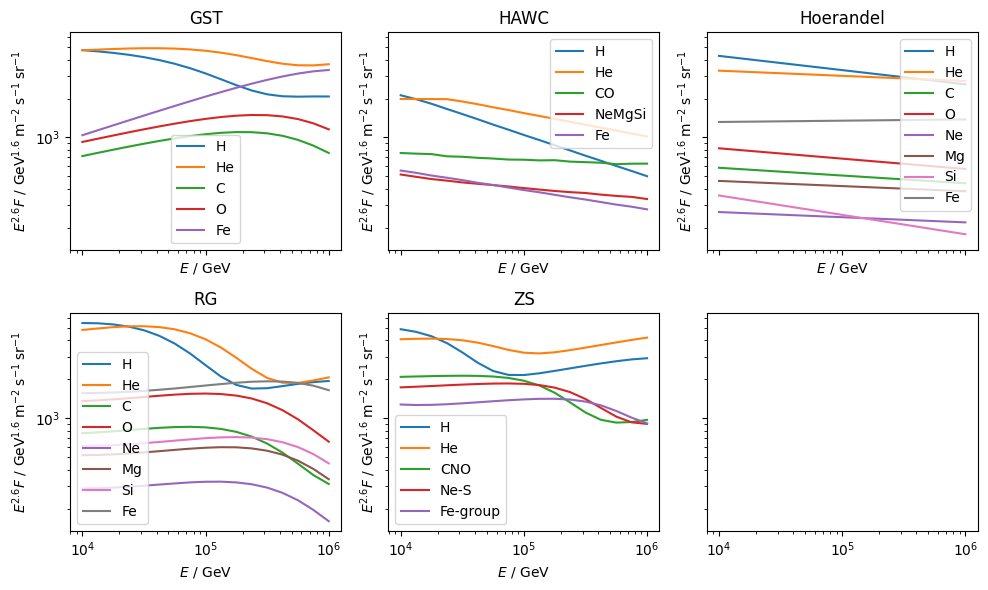

In [3]:
import matplotlib.pyplot as plt

from cr_knee_fit.utils import label_energy_flux

fig, axes = plt.subplots(nrows=2, ncols=3, sharex=True, sharey=True, figsize=(10, 6))

scale = 2.6
for ax, model in zip(
    axes.flatten(),
    (
        "GST",
        "HAWC",
        "Hoerandel",
        "RG",
        "ZS",
    ),
):
    for fd in load_fluxes(model):
        ax.loglog(fd.E, fd.E**scale * fd.F, label=fd.primary)

    ax.legend()
    ax.set_title(model)
    label_energy_flux(ax, scale=scale)

fig.tight_layout()

In [4]:
from cr_knee_fit import experiments
from cr_knee_fit.fit_data import FitData
from cr_knee_fit.types_ import Primary


fit_data = FitData.load(
    experiments_detailed=experiments.direct_experiments + [experiments.grapes],
    experiments_all_particle=[experiments.dampe],
    experiments_lnA=[],
    primaries=Primary.all(),
    R_bounds=(7e2, 1e19),
)

In [11]:
primary_weight = {
    "C": 5,
    "O": 1,
    "Ne": 2,
    "Mg": 3,
    "Si": 12,
    "Fe": 1,
}

Total weight: 26


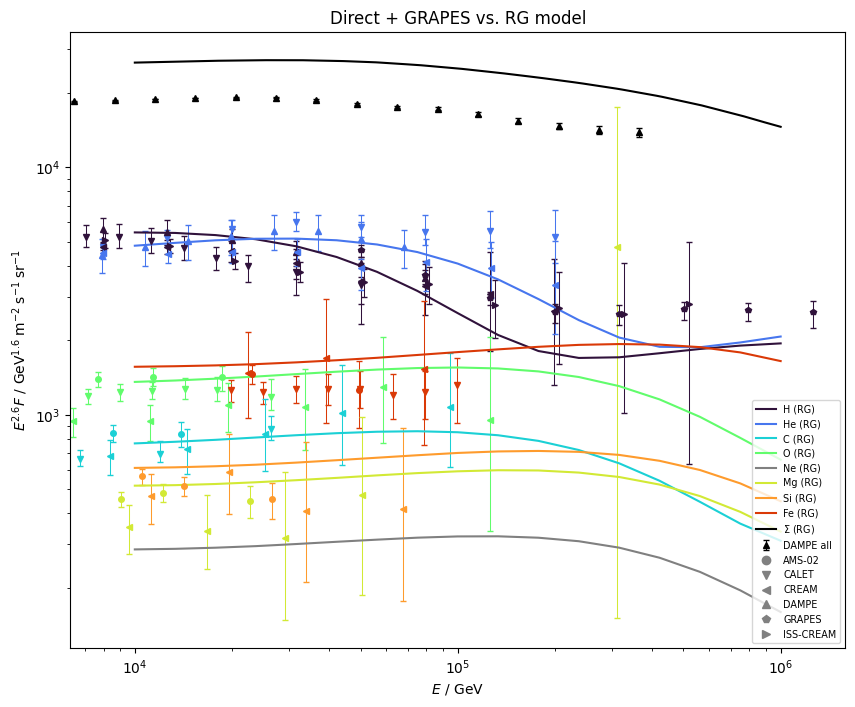

In [12]:
from cr_knee_fit.utils import add_log_margin, legend_with_added_items


scale = 2.6
fig = fit_data.plot(scale=scale)
ax = fig.axes[0]
rg = load_fluxes("RG")
for comp in rg:
    try:
        color = Primary[comp.primary].color
    except Exception:
        color = "gray"
    ax.plot(
        comp.E,
        comp.E**scale * comp.F,
        label=f"{comp.primary} ({comp.model})",
        color=color,
    )

E_grid = np.logspace(4, 6, 1000)
rg_sum = np.zeros_like(E_grid)
total_weight = 0
for comp in rg:
    weight = primary_weight.get(comp.primary, 1)
    total_weight += weight
    rg_sum += weight * np.exp(np.interp(np.log(E_grid), np.log(comp.E), np.log(comp.F)))
    # rg_sum += np.interp(E_grid, comp.E, comp.F)
print("Total weight:", total_weight)
ax.plot(E_grid, E_grid**scale * rg_sum, label=f"$\\Sigma$ ({rg[0].model})", color="k")

legend_with_added_items(
    ax,
    [(exp.legend_artist(), exp.name) for exp in sorted(fit_data.spectra.keys())],
    fontsize="x-small",
)

ax.set_title("Direct + GRAPES vs. RG model")
_ = ax.set_xlim(add_log_margin(1e4, 1e6))

In [10]:
from cr_knee_fit.cr_model import CosmicRaysModelConfig, SpectralBreakConfig
from cr_knee_fit.model import Model, ModelConfig


# see unobserved-subfit.ipynb
mle_model_config = ModelConfig(
    cr_model_config=CosmicRaysModelConfig(
        components=[
            [Primary.H],
            [Primary.He],
            [
                Primary.C,
                Primary.O,
                Primary.Mg,
                Primary.Si,
                Primary.Fe,
            ],
        ],
        breaks=[
            SpectralBreakConfig(fixed_lg_sharpness=np.log10(5)),
            SpectralBreakConfig(fixed_lg_sharpness=np.log10(10)),
        ],
        rescale_all_particle=False,
    ),
    shifted_experiments=[],
)
mle_model = Model.unpack(
    theta=np.array(
        [
            -4.10092571,
            2.61851438,
            -4.66115271,
            2.51108754,
            -6.17748255,
            -6.15721123,
            -6.86917724,
            -6.9129767,
            -6.95478031,
            2.54434144,
            4.28369294,
            0.21636823,
            5.41581888,
            -0.2542753,
        ]
    ),
    layout_info=mle_model_config,
)

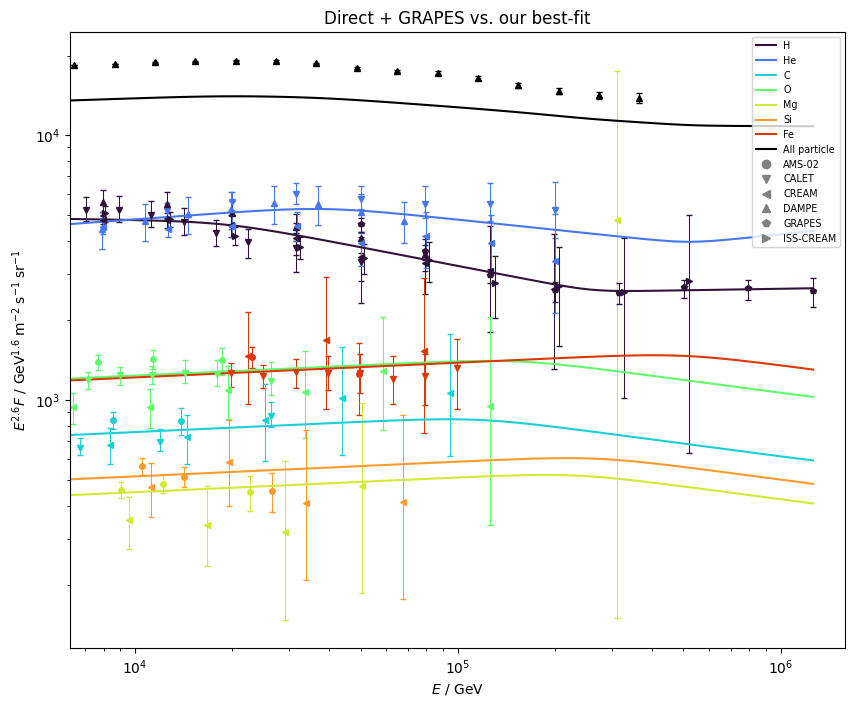

In [11]:
scale = 2.6
fig = mle_model.plot(fit_data, scale=scale)
ax = fig.axes[0]
ax.set_title("Direct + GRAPES vs. our best-fit")

_ = ax.set_xlim(add_log_margin(1e4, 1e6))